# Severstal: Steel Defect Detection

Steel is one of the most important building materials of modern times. Steel buildings are resistant to natural and man-made wear which has made the material ubiquitous around the world.

Severstal is leading the charge in efficient steel mining and production. They believe the future of metallurgy requires development across the economic, ecological, and social aspects of the industry—and they take corporate responsibility seriously.

## 1. Business Problem

### 1.1 Description

Steel Defect Detection is a competition hosted on kaggle by one of the largest steel manufacture company Severstal. Since the production process of flat sheet steel involves line up of many sub-processes in which this flat sheet has to touch several machines by the time it’s ready to ship. So Severstal is using images from high frequency cameras to power a defect detection algorithm. Through this competition, Severstal is expecting participants to improve the algorithm by localizing and classifying surface defects on a steel sheet.

competetion Link: https://www.kaggle.com/c/severstal-steel-defect-detection

## 1.2 Sources/Useful Links

Data Source : 
- https://www.kaggle.com/c/severstal-steel-defect-detection/data

Research Papers/Blogs/Kernels :
1. https://medium.com/analytics-vidhya/severstal-steel-defect-detection-5e5b50fe21ce
2. https://medium.com/@guildbilla/steel-defect-detection-image-segmentation-using-keras-dae8b4f986f0
3. https://towardsdatascience.com/semantic-image-segmentation-using-fully-convolutional-networks-bf0189fa3eb8
4. https://medium.com/@saivenkat_/a-detailed-case-study-on-severstal-steel-defect-detection-can-we-detect-and-classify-defects-in-2844402392cc
5. https://medium.com/@gargishan209/detection-of-steel-defects-image-segmentation-using-keras-and-tensorflow-37e8ae8aabe8
6. https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
7. https://www.kaggle.com/titericz/building-and-visualizing-masks



## 1.3 Real world/Business Objectives and Constraints

- The objective of this competition is to predict the location and type of defects found in steel manufacturing using the images provided.

# 2. Machine Learning Probelm

## 2.1 Data 

### 2.1.1 Data Overview 

Files:
- train_images/ - folder of training images - 12568 file(.jpg)
- test_images/ - folder of test images (you are segmenting and classifying these images) - 5506 files(.jpg)
- train.csv - training annotations which provide segments for defects (ClassId = [1, 2, 3, 4])
- sample_submission.csv - a sample submission file in the correct format; note, each ImageId 4 rows, one for each of the 4 defect classes

Each image may have no defects, a defect of single class or defects of multiple class. There are four classes of defects.

snap view of first few lines of train.csv:
<pre>
ImageId,ClassId,EncodedPixels
0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 ....... 192843 23 193099 14 193355 5
0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 ..... 298245 251 298564 188 298945 63
000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 ..... 117576 27 117843 16 118109 6
000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 .... 289263 2 289519 2 289776 1
</pre>

train.csv contains 7095 of rows. The 3 columns of the train.csv are ImageId, ClassId and EncodedPixels. 
1. ImageId: Unique Id for each image.
2. ClassId: Type/class Id of defect that image has at the pixel locations mentioned in the EncodedPixels column.
3. EncodedPixels: This column gives info about the pixel location of the defect in the image. The defective pixel locations lists are encoded to list of pairs of values (1st value of each pair represents start position and the 2nd value represents it’s run length) to reduce the file size.


## 2.2 Mapping the real world problem to an ML problem

### 2.2.1 Type of Machine Leaning Problem 

It is an image segmentation problem, for a given image we need to detect and localize the defect in the steel sheet.

### 2.2.2 Performance Metric 

This competition is evaluated on the mean <a href='https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient'>Dice coefficient</a>. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:

\begin{align*}
\frac{2 * |X \cap Y|}{|X| + |Y|}
\end{align*}<br>
where X is the predicted set of pixels and Y is the ground truth. The Dice coefficient is defined to be 1 when both X and Y are empty.

## 3. Exploratory data analysis

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

import random

In [2]:
#loading train.csv using pandas
df = pd.read_csv('train.csv/train.csv')

In [3]:
#printing the shape of dataframe & dataframe head
print('Shape of dataframe: ', df.shape)
df.head()

Shape of dataframe:  (7095, 3)


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [4]:
#stripping ImageId strings
df['ImageId'] = df['ImageId'].apply(lambda x: x.strip())
#fetching details about ImageId column
df.ImageId.describe()

count              7095
unique             6666
top       db4867ee8.jpg
freq                  3
Name: ImageId, dtype: object

- No null values in ImageId column since 'Count' & 'size'(of datframe) values are equal/same.
- Out of 7095 rows, 6666 unique image ids are found.
- Most repeated image('db4867ee8.jpg') was repeated '3' .

In [5]:
train_img_set = set(list(os.listdir('train_images')))
print('Total number of images in train_images folder: ', len(train_img_set))
defect_img_set = set(df['ImageId'].values)
print('Total number of images that are included in train.csv: ', len(defect_img_set))
if (defect_img_set.issubset(train_img_set)):
    print('All the ImageId that are mentioned in train.csv are present in train_images folder.')

Total number of images in train_images folder:  12568
Total number of images that are included in train.csv:  6666
All the ImageId that are mentioned in train.csv are present in train_images folder.


- Out of 12568 images, 6666 are defective.

Number of ImageIds that are not defective:  5902


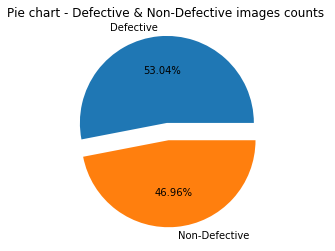

In [6]:
print('Number of ImageIds that are not defective: ', len(train_img_set) - len(defect_img_set))
non_defect_img_set = train_img_set - defect_img_set

#plotting pie-chart for their counts
plt.pie([len(defect_img_set), len(non_defect_img_set)], labels = ['Defective', 'Non-Defective'], explode = [0.1]*2, startangle = 0, autopct='%1.2f%%')
plt.title('Pie chart - Defective & Non-Defective images counts ')
plt.show()

In [7]:
df['ClassId'].astype('str').describe()

count     7095
unique       4
top          3
freq      5150
Name: ClassId, dtype: object

- No null values found in ClassId column(dataframe size & count are equal)
- 4 unique values in column ClassId
- most repeated ClassId is '3' with frequency; 5150

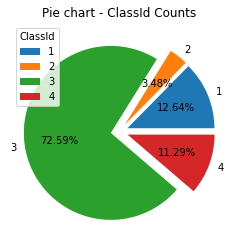

,ClassId,Count,count-percentage
0,1,897,12.642706
1,2,247,3.481325
2,3,5150,72.586328
3,4,801,11.289641


In [8]:
ClassId_cnt_df = pd.DataFrame(df['ClassId'].value_counts().sort_index()).rename(columns = {'ClassId':'Count'})
ClassId_cnt_df['count-percentage'] = ClassId_cnt_df*100/ClassId_cnt_df.sum()

plt.pie(ClassId_cnt_df['Count'], labels = ClassId_cnt_df['Count'].index, explode = [0.1]*4, startangle = 0, autopct='%1.2f%%')
plt.legend(title = "ClassId")
plt.title('Pie chart - ClassId Counts')
plt.show()

ClassId_cnt_df.reset_index().rename(columns = {'index':'ClassId'})

- These defective data-points are highly imbalanced.
- majority of the data-points(72.6%) are of ClassId - 3. 
- ClassId - 1 & 2 have almost equal share (12.6% & 11.3% respectively).
- Datapoints with ClassId - 2 has the lowest share among all.

In [9]:
#Number of labels for each image
#grouping dataframe by ImageIds & getting count of classes labeled for each image
nos_labels_per_img_df = df.groupby('ImageId')['ClassId'].count()#reset_index()#.rename(columns = {'ClassId':'Count'})
nos_labels_per_img_df.head(10)

ImageId
0002cc93b.jpg    1
0007a71bf.jpg    1
000a4bcdd.jpg    1
000f6bf48.jpg    1
0014fce06.jpg    1
0025bde0c.jpg    2
002af848d.jpg    1
002fc4e19.jpg    2
0030401a5.jpg    1
0046839bd.jpg    1
Name: ClassId, dtype: int64

In [10]:
data = nos_labels_per_img_df.value_counts().sort_index()
for index, value in data.items():
    print("Number of images with {} number of defect labels: {}".format(index, value))

Number of images with 1 number of defect labels: 6239
Number of images with 2 number of defect labels: 425
Number of images with 3 number of defect labels: 2


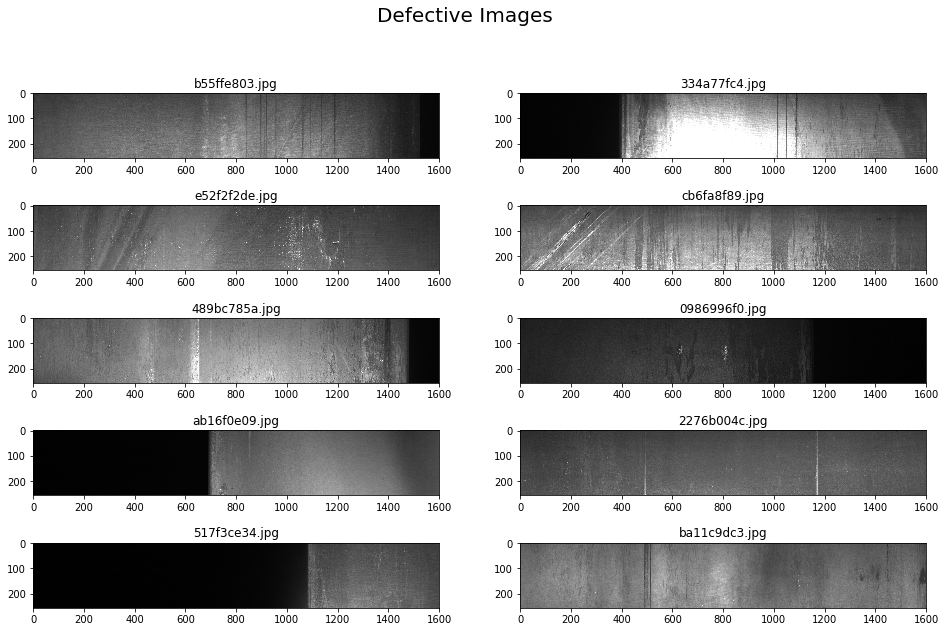

In [11]:
#displaying few images from defective image set
fig, axs = plt.subplots(5, 2, figsize=(16,10))
fig.suptitle('Defective Images', fontsize=20)
x,y = 0,0
for i, img_id in enumerate(random.sample(defect_img_set, 10)):
    img_obj = cv2.imread('train_images/'+ img_id)
    axs[i//2,i%2].imshow(img_obj)
    axs[i//2,i%2].set_title(img_id)
plt.show()

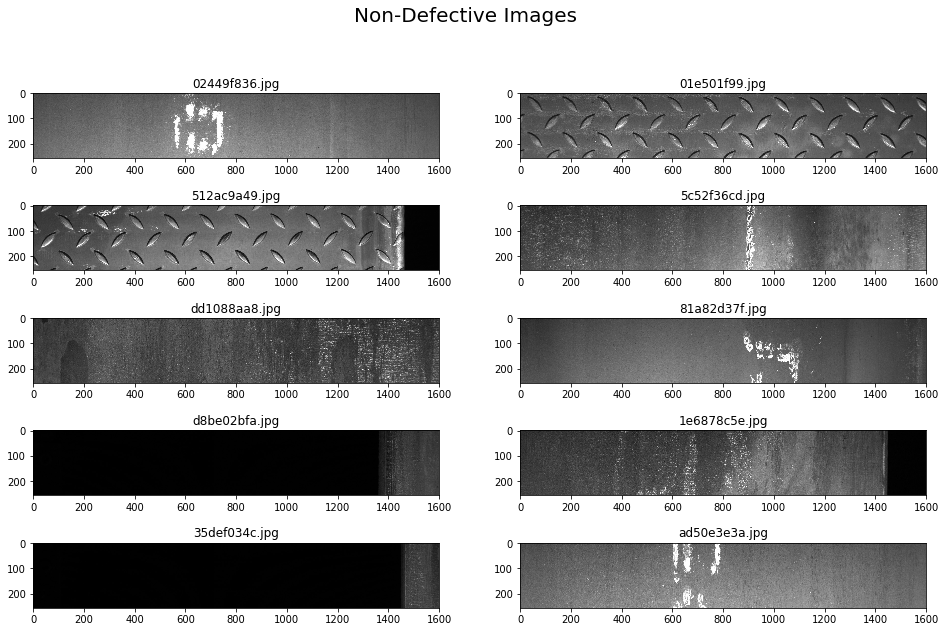

In [12]:
#displaying few images from non-defective image set
fig, axs = plt.subplots(5, 2, figsize=(16,10))
fig.suptitle('Non-Defective Images', fontsize=20)
x,y = 0,0
for i, img_id in enumerate(random.sample(non_defect_img_set, 10)):
    img_obj = cv2.imread('train_images/'+ img_id)
    axs[i//2,i%2].imshow(img_obj)
    axs[i//2,i%2].set_title(img_id)
plt.show()

- It looks like even some of the images from Non-defective set(ImgaeIds that are not in train.csv) are defective. May be these defect classes are not in [1, 2, 3, 4].

In [13]:
#checking if all the images in train_images folder are of same shape
img_shapes = set()
for img in list(os.listdir('train_images')):
    img_shapes.add(cv2.imread('train_images/'+img).shape)
img_shapes

{(256, 1600, 3)}

- Hence, all the images are of same shapes i.e., (256, 1600, 3)

In [14]:
#https://www.kaggle.com/titericz/building-and-visualizing-masks
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

#defining function for converting EncodedPixels(rle: run length encoding) to mask
def rle2mask(rle_string, img_shape=(256,1600)):
    '''
    input: EncodedPixels (run-length-encoded) string & image shape:-(width,height)
    output: mask in numpy.ndarray format with shape (256,1600)
    '''
    rle_array = np.array([int(s)for s in rle_string.split()])
    starts_array = rle_array[::2]-1
    lengths_array = rle_array[1::2]
    mask_array = np.zeros(img_shape[0]*img_shape[1],dtype=np.uint8)
    #print(starts_array,lengths_array)
    for i in range(len(starts_array)):
        mask_array[starts_array[i]:starts_array[i]+lengths_array[i]] = 1
    #order='F' because encoded pixels are numbered from top to bottom, then left to right
    return mask_array.reshape(img_shape, order = 'F')

#defining function for converting given mask to EncodedPixels(rle: run length encoding)
def mask2rle(mask_array):
    '''
    input: mask in numpy.ndarray format
    output: EncodedPixels (run-length-encoded) string
    '''
    mask_array = mask_array.T.flatten()
    mask_array = np.concatenate([[0], mask_array, [0]])
    rle_array = np.where(mask_array[1:]!=mask_array[:-1])[0]+1
    rle_array[1::2] -= rle_array[::2]
    rle_string = ' '.join(map(str,rle_array))
    return rle_string

In [15]:
#checking if rle2mask & mask2rle are working as required
mask2rle(rle2mask(df['EncodedPixels'].iloc[0])) == df['EncodedPixels'].iloc[0]

True

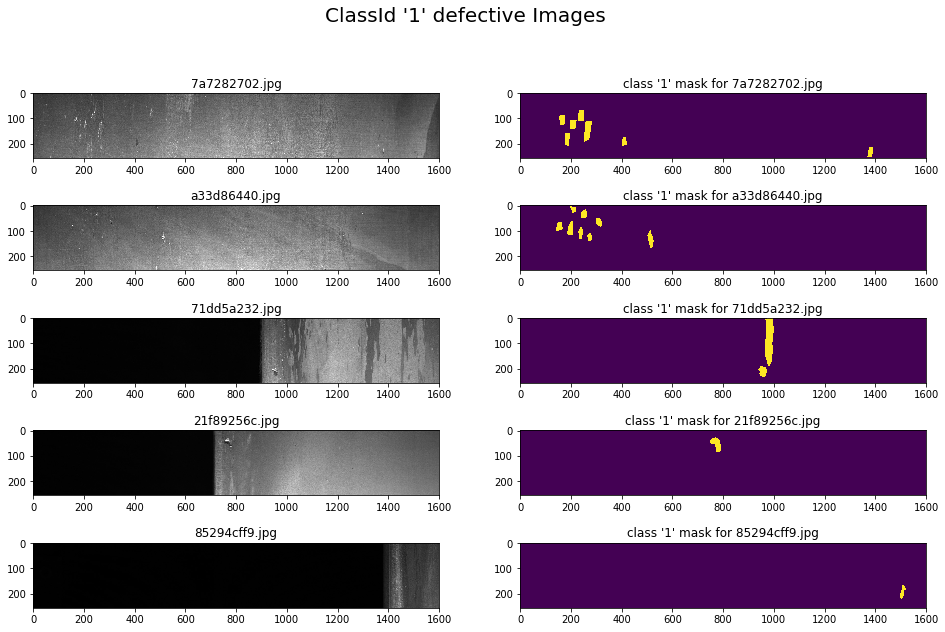

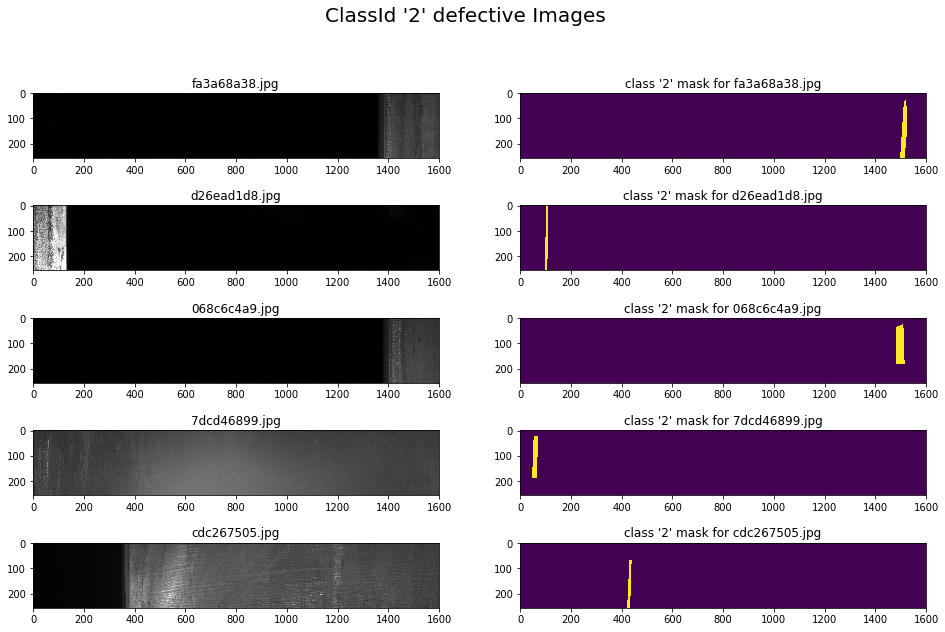

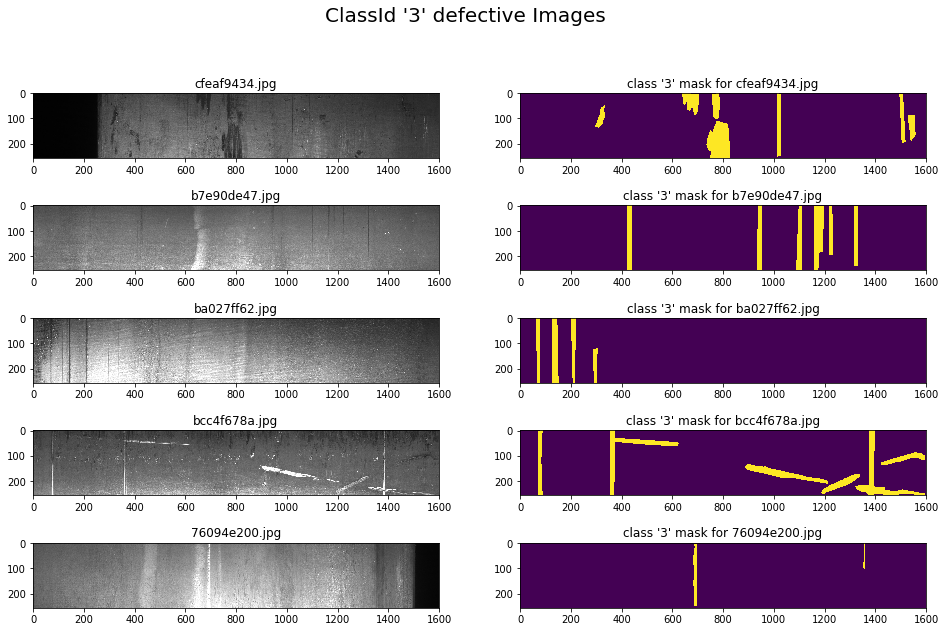

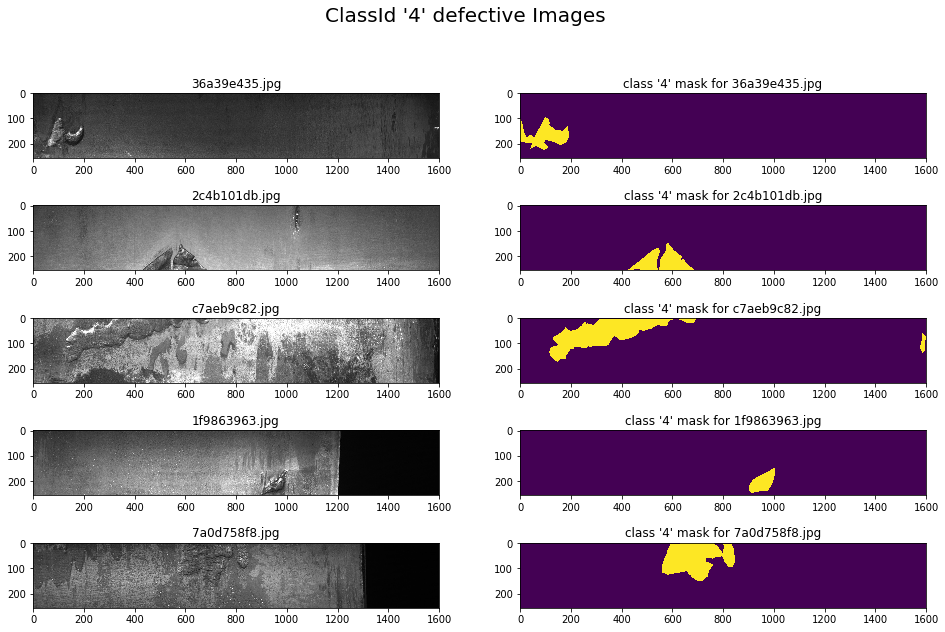

In [16]:
#displaying few defective images for each ClassIds 
for ClassId in [1,2,3,4]:
    class_df = df[df['ClassId'] == ClassId]
    fig, axs = plt.subplots(5, 2, figsize=(16,10))
    fig.suptitle("ClassId '{}' defective Images".format(ClassId), fontsize=20)
    x,y = 0,0
    for i, img_id in enumerate(random.sample(set(class_df['ImageId'].values), 5)):
        img_obj = cv2.imread('train_images/'+ img_id)
        axs[i,0].imshow(img_obj)
        axs[i,0].set_title(img_id)
        rle = class_df[class_df['ImageId'] == img_id]['EncodedPixels'].iloc[0]
        mask = rle2mask(rle)
        axs[i,1].imshow(mask)
        axs[i,1].set_title("class '{}' mask for ".format(ClassId) + img_id)
    plt.show()
    print('='*100)

- From the mask images, Class '2' defects have lesser defect areas when compared to other classes. And class '3' & '4' defects have more defect area when compared to others


## 4. Data Preperation

In [17]:
#Creating dataframe for all the images in the train_images
train_images_list = list(os.listdir('train_images'))
length = len(train_images_list)
train_images_list = train_images_list*4
ClassIds = [1]*length + [2]*length + [3]*length + [4]*length

full_df = pd.DataFrame({'ImageId':train_images_list, 'ClassId':ClassIds})
full_df = full_df.sort_values(by = ['ImageId', 'ClassId']).reset_index(drop = True)
print(full_df.shape)
full_df.head(8)

(50272, 2)


,ImageId,ClassId
0,0002cc93b.jpg,1
1,0002cc93b.jpg,2
2,0002cc93b.jpg,3
3,0002cc93b.jpg,4
4,00031f466.jpg,1
5,00031f466.jpg,2
6,00031f466.jpg,3
7,00031f466.jpg,4


In [18]:
#merging both full_df & df
full_df = pd.merge(full_df, df, how ='outer', on= ['ImageId', 'ClassId'])
full_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg,2,NaN
2,0002cc93b.jpg,3,NaN
3,0002cc93b.jpg,4,NaN
4,00031f466.jpg,1,NaN


In [19]:
#https://www.geeksforgeeks.org/python-pandas-pivot_table/ 
full_df = pd.pivot_table(full_df, columns = ['ClassId'], index= ['ImageId'], aggfunc=np.sum).replace(0,'')
full_df = full_df.reset_index()
full_df.columns = ['ImageId', 'rle_1', 'rle_2', 'rle_3', 'rle_4']
full_df.to_csv("full_data.csv", index=False)
print('Shape of full_df: ', full_df.shape)
full_df.head()

Shape of full_df:  (12568, 5)


,ImageId,rle_1,rle_2,rle_3,rle_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,
